# Task 3A: Feature Engineering w/ Graph Data

## Problem Description
In addition to the selected features in Task 2A and 2B, add new features engineered from graph data. The new features include:
- EMT_SUM_OUT: Total Amount in EMTs Sent
- EMT_SUM_IN: Total Amount in EMTs Received
- OUTGOING_BA: Number of Transactions Sent to Bad Actors
- INCOMING_BA: Number of Transactions Received from Bad Actors

In [34]:
# import basic modules
import pandas as pd
import numpy as np
import urllib
import warnings
import zipfile 
warnings.filterwarnings("ignore")

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
plt.style.use('ggplot')

# import statistic modules
from scipy import stats
from scipy.stats import chi2_contingency

# import relevant sklean modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, mean_squared_error,classification_report, precision_score, recall_score
from sklearn.metrics import make_scorer, confusion_matrix

In [3]:
# unzip data
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall()

# read in kyc data
file_path = 'UofT_nodes.csv'
df = pd.read_csv(file_path,  dtype=str)

In [4]:
# Preprocess string variables into numerical variables
df['COUNTRY_RISK_INCOME'] = df['COUNTRY_RISK_INCOME'].astype('category').cat.codes
df['COUNTRY_RISK_RESIDENCY'] = df['COUNTRY_RISK_RESIDENCY'].astype('category').cat.codes
df['RISK'] = df['RISK'].replace(['low'], 0)
df['RISK'] = df['RISK'].replace(['medium'], 1)
df['RISK'] = df['RISK'].replace(['high'], 2)
df['GENDER'] = df['GENDER'].astype('category').cat.codes
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype(float)

# Set numeric variables as float data type
for i in range(2, 13):
  df.iloc[:, i] = df.iloc[:, i].astype(float)

In [5]:
# Retain relevant columns
feature = ['CUSTOMER_ID','PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
           'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
           'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'RISK']
df_new = df[feature]

## For 2A Models

In [6]:
# read in graph and bad actor datasets
df_edges = pd.read_csv('UofT_edges.csv')
df_ba = pd.read_csv('0_final_badactors_list.csv', index_col=0)

In [7]:
len(df_ba)

50

In [8]:
# identify bad actors in the processed kyc data
bad_actors = df_ba['CUSTOMER_ID'].tolist()
df_new['BAD_ACTOR'] = df_new['CUSTOMER_ID'].isin(bad_actors).astype(int)

In [9]:
# identify num of OUTGOING payments users have with bad actors
df_new_v1 = df_new.merge(df_edges, left_on="CUSTOMER_ID", right_on="source", how="left")\
                   .drop("source",axis=1)\
                   .rename(columns={'emt':'EMT_SUM_OUT'}) # join kyc and graph data

df_new_v1['OUTGOING_BA'] = df_new_v1['target'].isin(bad_actors).astype(int)
df_new_v1 = df_new_v1.drop("target", axis=1).fillna(0)

# take a sum of the outgoing emt amount per user
df_new_v1 = df_new_v1.groupby(df_new.columns.tolist()).sum().reset_index()

In [10]:
# identify num of INCOMING payments users have with bad actors
df_new_v2 = df_new_v1.merge(df_edges, left_on="CUSTOMER_ID", right_on="target", how="left")\
                   .drop("target",axis=1)\
                   .rename(columns={'emt':'EMT_SUM_IN'})

df_new_v2['INCOMING_BA'] = df_new_v2['source'].isin(bad_actors).astype(int)
df_new_v2 = df_new_v2.drop("source", axis=1).fillna(0)

# take a sum of the incoming emt amount per user
df_graph = df_new_v2.groupby(df_new_v1.columns.tolist()).sum().reset_index()

# remove customer id from final datasets
df_graph.drop('CUSTOMER_ID', axis=1, inplace=True)
df_new.drop('CUSTOMER_ID', axis=1, inplace=True)

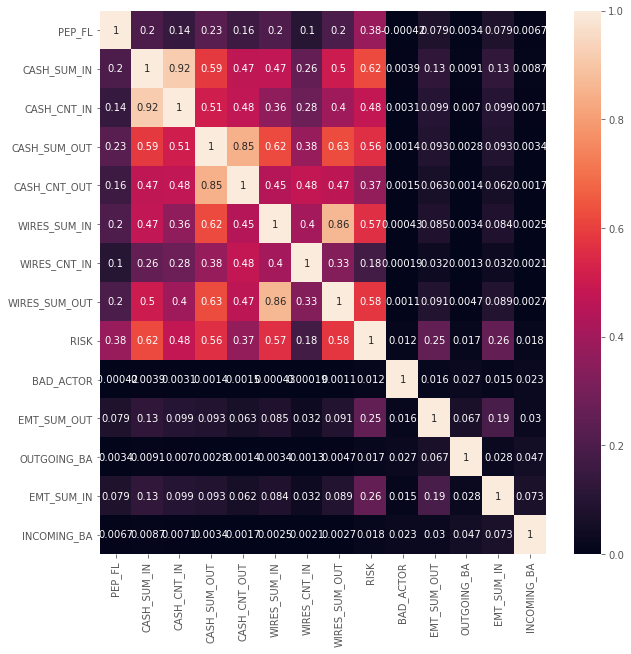

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(df_graph.corr(), annot=True)
plt.show()

## For Task 2B Models

In [12]:
# Convert Key(Customer ID) to int for join
df.CUSTOMER_ID = df.CUSTOMER_ID.astype(float).astype(int)

# Change all date to date format
df.BIRTH_DT = pd.to_datetime(df.BIRTH_DT)
df.CUST_ADD_DT = pd.to_datetime(df.CUST_ADD_DT)

# Fill NaN with value different from the other
df.CUST_ADD_DT.fillna(pd.Timestamp('1800-01-01'), inplace=True)
df.OCPTN_NM.fillna(-1, inplace=True)

# Convert all dates to Unix timestamps for modeling
df['BIRTH_TS'] = df['BIRTH_DT'].apply(lambda x: x.timestamp())
df['CUST_ADD_TS'] = df['CUST_ADD_DT'].apply(lambda x: x.timestamp())
df_graph2 = df.copy()

# identify bad actors in the processed kyc data
df_graph2['BAD_ACTOR'] = df_graph2['CUSTOMER_ID'].isin(bad_actors).astype(int)

In [13]:
# Set variable will be used for training (from 2B)
select_features = ['COUNTRY_RISK_INCOME','CNTRY_OF_INCOME_CA','RES_CNTRY_CA',
                   'CASH_SUM_IN','COUNTRY_RISK_RESIDENCY','CASH_CNT_IN',
                   'WIRES_CNT_OUT','CASH_CNT_OUT','CASH_SUM_OUT','WIRES_SUM_OUT']

In [14]:
# identify num of OUTGOING payments users have with bad actors
df_new_v1 = df_graph2.merge(df_edges, left_on="CUSTOMER_ID", right_on="source", how="left")\
                   .drop("source",axis=1)\
                   .rename(columns={'emt':'EMT_SUM_OUT'}) # join kyc and graph data

df_new_v1['OUTGOING_BA'] = df_new_v1['target'].isin(bad_actors).astype(int)
df_new_v1 = df_new_v1.drop("target", axis=1).fillna(0)

# take a sum of the outgoing emt amount per user
df_new_v1 = df_new_v1.groupby(df_new_v1.columns.tolist()).sum().reset_index()

In [15]:
# identify num of INCOMING payments users have with bad actors
df_new_v2 = df_new_v1.merge(df_edges, left_on="CUSTOMER_ID", right_on="target", how="left")\
                   .drop("target",axis=1)\
                   .rename(columns={'emt':'EMT_SUM_IN'})

df_new_v2['INCOMING_BA'] = df_new_v2['source'].isin(bad_actors).astype(int)
df_new_v2 = df_new_v2.drop("source", axis=1).fillna(0)

# take a sum of the incoming emt amount per user
df_graph2 = df_new_v2.groupby(df_new_v1.columns.tolist()).sum().reset_index()

# remove customer id from final datasets
df_graph2.drop('CUSTOMER_ID', axis=1, inplace=True)

# Task 2A Models
## Resampling

In [16]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [22]:
# Split into train and test sets
X = df_graph.drop(['RISK', 'BAD_ACTOR'], axis=1)
y = df_graph['RISK']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=40)

In [30]:
# Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# SMOTENN
smoteenn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smoteenn.fit_resample(X_train, y_train)

## Logistic

In [26]:
# Best resampled data and logistic model
X_train_best = X_resampled_smote
y_train_best = y_resampled_smote

best_model = LogisticRegression(C=10, multi_class='auto', solver='lbfgs')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

# Results from best resampled data and model
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.92744
precision: 0.9607132254290183
recall: 0.92744


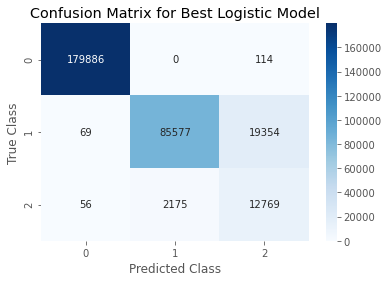

In [27]:
# Plot confusion matrix
cm_log = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix for Best Logistic Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

## RF

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Best resampled data and RF model
X_train_best = X_resampled_smote
y_train_best = y_resampled_smote

best_model = RandomForestClassifier(max_depth=40, random_state=0)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9594366666666667
precision: 0.9627671839190288
recall: 0.9594366666666667


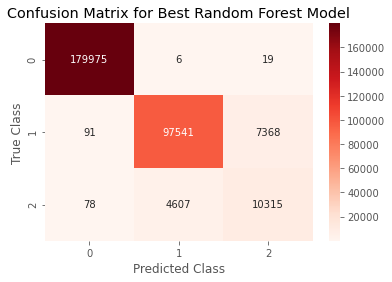

In [29]:
# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds')

# Add labels to the plot
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

## Decision Tree

In [35]:
# Best resampled data and DT model
X_train_best = X_resampled_smoteenn
y_train_best = y_resampled_smoteenn

best_model = DecisionTreeClassifier(max_depth=21, min_samples_split=2, random_state=0)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.93858
precision: 0.9584129011750742
recall: 0.93858


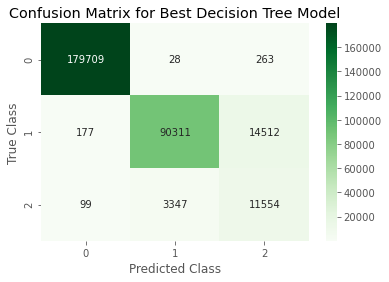

In [36]:
# Plot confusion matrix
cm_dt = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')

# Add labels to the plot
plt.title('Confusion Matrix for Best Decision Tree Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

## SGD (Logistic & SVM)

In [37]:
# Best resampled data and logistic model
X_train_best = X_resampled_rus
y_train_best = y_resampled_rus

best_model = SGDClassifier(loss="log", penalty="l2", max_iter=20)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

# Results from best resampled data and model
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9263966666666666
precision: 0.9559782724452968
recall: 0.9263966666666666


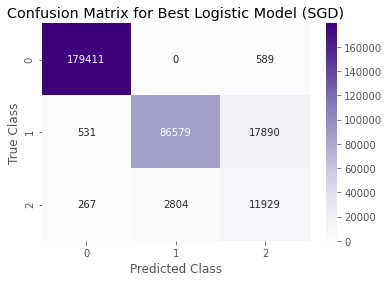

In [38]:
# Plot confusion matrix
cm_log_sgd = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_log_sgd, annot=True, fmt='d', cmap='Purples')

# Add labels to the plot
plt.title('Confusion Matrix for Best Logistic Model (SGD)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

In [39]:
# Best resampled data and svm model
X_train_best = X_resampled_ros
y_train_best = y_resampled_ros

best_model = SGDClassifier(loss="hinge", penalty="l2", max_iter=20)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train_best)

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

# Results from best resampled data and model
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9240633333333333
precision: 0.9559759186769463
recall: 0.9240633333333333


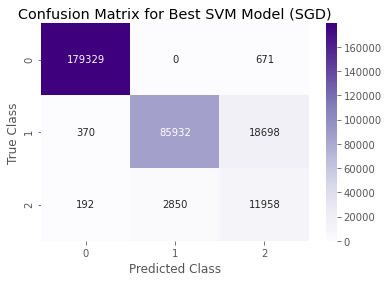

In [40]:
# Plot confusion matrix
cm_svm_sgd = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm_sgd, annot=True, fmt='d', cmap='Purples')

# Add labels to the plot
plt.title('Confusion Matrix for Best SVM Model (SGD)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

# Task 2B Models
## Logistic

In [41]:
# Remove feature names
X = df_graph2[select_features + ['EMT_SUM_OUT','EMT_SUM_IN','OUTGOING_BA','INCOMING_BA']].values
y = df_graph2.BAD_ACTOR

# Create a StratifiedKFold object with 5 folds (Avoid imbalanced issue)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
scaler = StandardScaler()

# Initialize an empty list to store the accuracy scores
acc_scores = []
prec_scores = []
rec_scores = []

for train_index, test_index in skf.split(X, y):
    # split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # normalize the training and testing data using the scaler
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    
    # initialize a LogisticRegression classifier
    lr = LogisticRegression(class_weight='balanced', random_state=7)
    
    # train the classifier on the normalized training data
    lr.fit(X_train_norm, y_train)
    
    # evaluate the classifier on the normalized testing data
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precison = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    acc_scores.append(accuracy)
    prec_scores.append(precison)
    rec_scores.append(recall)

print('Average accuracy:', np.mean(acc_scores))
print('Average precision:', np.mean(prec_scores))
print('Average recall:', np.mean(rec_scores))

Average accuracy: 0.9761067117459522
Average precision: 0.9997638361474521
Average recall: 0.9761067117459522
